In [1]:
from keras import backend as K
from keras.applications import inception_v3

K.set_learning_phase(value=0)

# Use only convolutional layers not classifier.
model = inception_v3.InceptionV3(weights='imagenet',
                                 include_top=False)

Using TensorFlow backend.


In [2]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [3]:
layer_contributions = {
    'mixed2': 0.2,
    'mixed3': 3.0,
    'mixed4': 2.0,
    'mixed5': 1.5,
}

In [4]:
loss = K.variable(0.0)

for layer_name in layer_contributions:
    layer = model.get_layer(name=layer_name)
    coef = layer_contributions[layer_name]
    activation = layer.output

    scaling = K.prod(K.cast(K.shape(activation), 'float32'))
    loss = loss + coef * K.sum(K.square(activation[:, 2:-2, 2:-2, :])) / scaling

In [5]:
dream = model.input

grads = K.gradients(loss, dream)[0]
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

outputs = [loss, grads]
# Make a function instance which output loss and gradients vector.
fetch_loss_and_grads = K.function(inputs=[dream], outputs=outputs)

In [6]:
def eval_loss_and_grads(x):
    # First index of function output is loss, second is gradient vector.
    output = fetch_loss_and_grads([x])
    loss_value = output[0]
    grads_value = output[1]
    return loss_value, grads_value

In [7]:
def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grads_value = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('iter = %d, loss_value =%s' % (i, loss_value))
        x += (step * grads_value)
    return x

In [8]:
import scipy
import numpy as np
from keras.preprocessing import image

def resize_img(img, size):
    img = np.copy(img)
    height_factor = size[0] / img.shape[1]
    width_factor = size[1] / img.shape[2]
    return scipy.ndimage.zoom(input=img, zoom=(1, height_factor, width_factor, 1), order=1)

def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    image.save_img(fname, pil_img)

def preprocess_image(image_path):
    '''
    Return a preprocessed image to input into InceptionV3 model.
    '''
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img

def deprocess_image(x):
    '''
    Covert a numpy array to the image file.
    '''
    # Theano format, channel first, (samples, depth, height, width).
    # Otherwise, tensorflow foramt, channel last, (samples, height, width, depth)
    if K.image_data_format() == 'channels_first':
        height = x.shape[2]
        width = x.shape[3]
        x = x.reshape((3, height, width))
        x = x.transpose(axis=(1, 2, 0))
    else:
        height = x.shape[1]
        width = x.shape[2]
        x = x.reshape((height, width, 3))
    # Reverse preprocessed operations in the InceptionV3 model.
    x /= 2.0
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [10]:
step = 0.01
num_octave = 3
octave_scale = 1.4
iterations = 20

max_loss = 10.0

base_image_path = './hemerocallis_lilioasphodelus.jpg'

img = preprocess_image(base_image_path)

original_shape = img.shape[1:3]
successive_shape = [original_shape]

for i in range(1, num_octave):
    shape = tuple([int(length / (octave_scale ** i)) for length in original_shape])
    successive_shape.append(shape)

successive_shape = np.flip(successive_shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


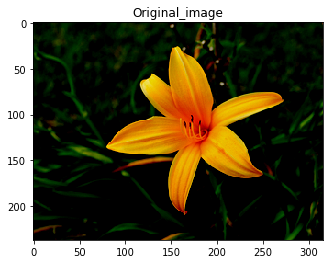

In [12]:
import matplotlib.pyplot as plt

plt.figure('Origianl image')
plt.title('Original_image')
plt.imshow(img[0,:,:,:])
plt.show()

In [13]:
# Deep dream operations has 3 scales.
print('succesive_shape =', successive_shape)

succesive_shape = [[161 120]
 [225 169]
 [316 237]]


In [14]:
original_img = img.copy()
shrunk_original_img = resize_img(img, successive_shape[0])

print('Shape of original image =', original_img.shape[1:3])
print('Shape of shrunk original image, top of the image prymid =', shrunk_original_img.shape[1:3])

Shape of original image = (237, 316)
Shape of shrunk original image, top of the image prymid = (161, 120)


In [15]:
for shape in successive_shape:
    print('Shape of image on the deep dream operation =', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    # Upscaling
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    # Downscaling or keep
    same_size_original = resize_img(original_img, shape)
    # Diffrence of upscaled and original iamge.
    lost_detail = same_size_original - upscaled_shrunk_original_img
    # Add details on this scale.
    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)
    save_img(img, fname=('dream_at_scale_%dx%d.png' % (shape[0], shape[1])))

save_img(img, fname='final_dream.png')

Shape of image on the deep dream operation = [161 120]
iter = 0, loss_value =0.58577126
iter = 1, loss_value =0.6992373
iter = 2, loss_value =1.0157557
iter = 3, loss_value =1.299416
iter = 4, loss_value =1.5538304
iter = 5, loss_value =1.8060716
iter = 6, loss_value =2.1206014
iter = 7, loss_value =2.435946
iter = 8, loss_value =2.6996982
iter = 9, loss_value =2.9006753
iter = 10, loss_value =3.2062583
iter = 11, loss_value =3.4663353
iter = 12, loss_value =3.7913973
iter = 13, loss_value =3.9830973
iter = 14, loss_value =4.160689
iter = 15, loss_value =4.368765
iter = 16, loss_value =4.6010146
iter = 17, loss_value =4.8856134
iter = 18, loss_value =5.0682964
iter = 19, loss_value =5.226806
Shape of image on the deep dream operation = [225 169]
iter = 0, loss_value =1.7782027
iter = 1, loss_value =2.7486413
iter = 2, loss_value =3.5509512
iter = 3, loss_value =4.3567176
iter = 4, loss_value =4.8979063
iter = 5, loss_value =5.6085076
iter = 6, loss_value =6.261676
iter = 7, loss_value 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


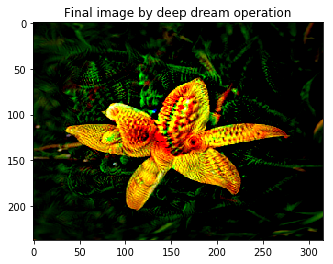

In [22]:
dream_img = img[0,:,:,:]
dream_img = np.transpose(dream_img, axes=[1, 0, 2])

plt.figure('Final image by deep dream operation')
plt.title('Final image by deep dream operation')
plt.imshow(dream_img)
plt.show()